In [218]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.pipeline import Pipeline
from pandas_profiling import ProfileReport
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

### Erster Blick in die Daten

In [220]:
URL = "https://datahub.io/machine-learning/adult/r/adult.csv"
#raw_data = os.path.join( "data", "data.csv")
raw_data = os.path.join("adult_csv.csv")
df_raw = pd.read_csv(raw_data, sep = ",")

In [221]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capitalgain     48842 non-null  int64 
 11  capitalloss     48842 non-null  int64 
 12  hoursperweek    48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [222]:
for col in df_raw:
    print(df_raw[col].unique())


[2 3 1 0 4]
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
[ 77516  83311 215646 ... 173449  89686 350977]
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
[1 0 4 2 3]
[0 3 1 2 4]
[2 0 3 4 1]
['United-States' 'Cuba' 'Jamaica' 'India' nan

### NA Daten checken

In [223]:
df_raw.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capitalgain          0
capitalloss          0
hoursperweek         0
native-country     857
class                0
dtype: int64

### Correlation Matrix

C:\Users\Lennart Reschke\AppData\Local\Temp\ipykernel_29728\456722157.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_raw.corr()


<AxesSubplot: >

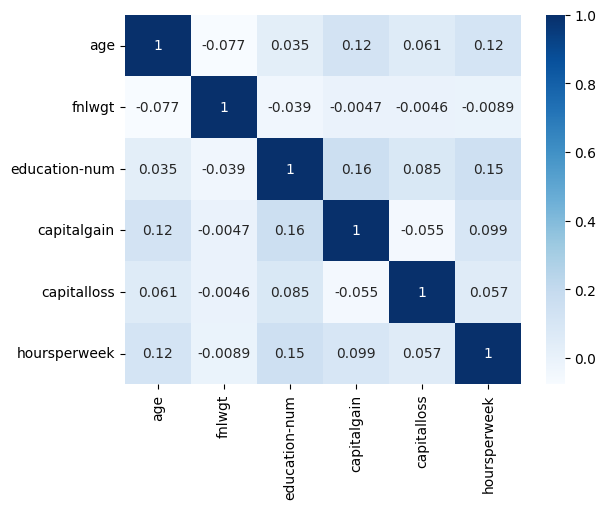

In [224]:
import seaborn as sns
%matplotlib inline
corr = df_raw.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

### Pandas Profiling Report
auskommentiert wegen GitHub

In [225]:
#html profile report erstellen um eine detaillierte Übersicht über die Zusammenhänge innerhalb des Datensatzes zu generieren
#profile = ProfileReport(df_raw, title="Countries Profiling Report", explorative=True)
#profile.to_notebook_iframe()

### education-num überflüssig?

c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\seaborn\distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='education-num', ylabel='Count'>

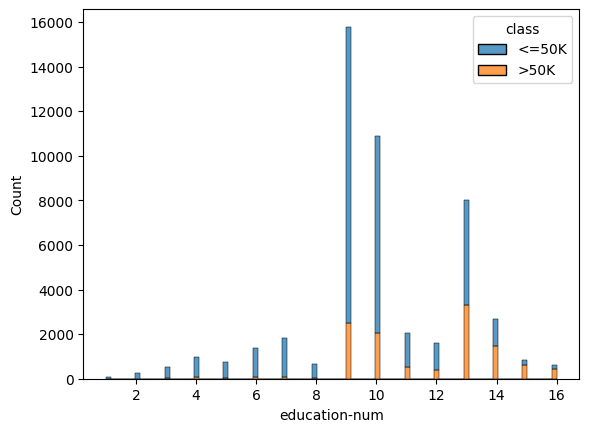

In [226]:
sns.histplot(data=df_raw, x="education-num", hue="class", multiple="stack")

#### Obwohl Korrelation zwischen education und education-num, Column wird nicht entfernt, da abnehmende "Skalenerträge" = Bei Grenze von 10 Jahren Education Anteil von >50k geht runter

### Scaling
2 Fragen:
    1. Welcher Scaler optimal?
    2. Welche Kateogiren müssen gescalet werden?

Test anhand Scaling von "fnlwgt"

In [227]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler

In [228]:
#Standard Scaler:
sd_scaler = StandardScaler()
sd_scaler.fit(df_raw[["fnlwgt"]])
sd_t = sd_scaler.transform(df_raw[["fnlwgt"]])
print(sd_t)
display(pd.DataFrame(sd_t).describe())

[[-1.06197924]
 [-1.00710388]
 [ 0.24603353]
 ...
 [ 1.75486457]
 [-1.00161161]
 [-0.07117353]]


,0
count,4.884200e+04
mean,-5.644539e-17
std,1.000010e+00
min,-1.679680e+00
25%,-6.828752e-01
50%,-1.090844e-01
75%,4.543232e-01
max,1.231723e+01


In [229]:
#Robust Scaler:
rob_scaler = RobustScaler()
rob_scaler.fit(df_raw[["fnlwgt"]])
rob_t = rob_scaler.transform(df_raw[["fnlwgt"]])
print(rob_t)
display(pd.DataFrame(rob_t).describe())

[[-0.83793191]
 [-0.78967704]
 [ 0.31227439]
 ...
 [ 1.63907104]
 [-0.78484739]
 [ 0.03333708]]


,0
count,48842.000000
mean,0.095924
std,0.879363
min,-1.381109
25%,-0.504565
50%,0.000000
75%,0.495435
max,10.927131


In [230]:
#MinMaxScaler:
mm_scaler = MinMaxScaler()
mm_scaler.fit(df_raw[["fnlwgt"]])
mm_t = mm_scaler.transform(df_raw[["fnlwgt"]])
print(mm_t)
display(pd.DataFrame(mm_t).describe())

[[0.04413121]
 [0.04805174]
 [0.13758131]
 ...
 [0.24537874]
 [0.04844413]
 [0.11491866]]


,0
count,48842.000000
mean,0.120004
std,0.071445
min,0.000000
25%,0.071216
50%,0.112210
75%,0.152462
max,1.000000


In [231]:
#QuantileScaler:
qt = QuantileTransformer()
qt.fit(df_raw[["fnlwgt"]])
qt_t = qt.transform(df_raw[["fnlwgt"]])
print(qt_t)
display(pd.DataFrame(qt_t).describe())

[[0.12078165]
 [0.1319937 ]
 [0.68506202]
 ...
 [0.94615963]
 [0.13354748]
 [0.51944007]]


,0
count,48842.000000
mean,0.500000
std,0.288685
min,0.000000
25%,0.250058
50%,0.499896
75%,0.750060
max,1.000000


,Standard,Robust,MinMax,QuantileTransformer
0,-1.061979,-0.837932,0.044131,0.120782
1,-1.007104,-0.789677,0.048052,0.131994
2,0.246034,0.312274,0.137581,0.685062
3,0.426663,0.471112,0.150486,0.741929
4,1.408530,1.334520,0.220635,0.911313


<AxesSubplot: ylabel='Density'>

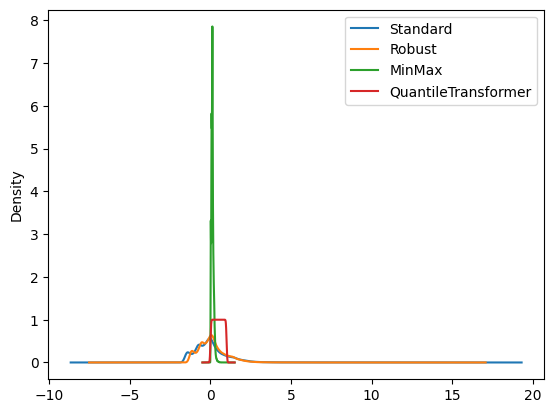

In [232]:
#Vergleich der Scaler
Sc_Vgl = pd.DataFrame(
    {
        "Standard": sd_t.flatten(),
        "Robust": rob_t.flatten(),
        "MinMax": mm_t.flatten(),
        "QuantileTransformer": qt_t.flatten(),
    }
)
display(Sc_Vgl.head())

Sc_Vgl.plot.kde()

Ergebnis zeigt: Standard & Robust Scaler liefern beinahe identische Ergebnisse. Beide werden weiter getestet. MinMax wird auch zum Vergleich mit in Durchlauf und Modellvergleich genommen.

The continuous variable fnlwgt represents final weight, which is the number of units in the target population that the responding unit represents.

### Preprocessing und Wrangling der Daten

#### Zusammenlegung von Workclass/Marital-Status rare categories

In [233]:
df_raw["workclass"].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [234]:
workclass_count = df_raw["workclass"].value_counts()
Nan_workclass = workclass_count[workclass_count < 100].index.to_list()
df_raw["workclass"] = df_raw["workclass"].astype("object")
df_raw.loc[df_raw.query(f"workclass == @Nan_workclass").index, "workclass"] = "Nan"

In [235]:
df_raw["workclass"].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Nan                    31
Name: workclass, dtype: int64

In [236]:
df_raw["marital-status"].value_counts()

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64

In [237]:
df_raw.rename(columns={"marital-status":"marital_status"}, inplace=True)

In [238]:
marital_status_count = df_raw["marital_status"].value_counts()
rare_marital_status = marital_status_count[marital_status_count < 1000].index.to_list()
df_raw["marital_status"] = df_raw["marital_status"].astype("object")
df_raw.loc[df_raw.query(f"marital_status == @rare_marital_status").index, "marital_status"] = "Married-civ-spouse"

In [239]:
df_raw["marital_status"].value_counts()

Married-civ-spouse    23044
Never-married         16117
Divorced               6633
Separated              1530
Widowed                1518
Name: marital_status, dtype: int64

#### Data Wrangling

In [240]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier

Entfernen von Holland-Netherlands, da es diesen Eintrag nur einmal gibt (daher nicht auf Train und Test aufgeteilt werden kann) und er sonst einen Fehler mit "unknown category" ausspuckt

In [241]:
df_raw["native-country"].value_counts()

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

In [242]:
indexNames = df_raw[df_raw['native-country'] == 'Holand-Netherlands'].index

df_raw.drop(indexNames , inplace=True)

## NANs beseitigen

In [243]:
print(df_raw.isna().sum())

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capitalgain          0
capitalloss          0
hoursperweek         0
native-country     857
class                0
dtype: int64


In [244]:
df_cleaned = df_raw.dropna()


In [245]:
print(df_cleaned.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capitalgain       0
capitalloss       0
hoursperweek      0
native-country    0
class             0
dtype: int64


Einteilung Train/Test Datensatz

In [246]:
train_data, test_data = train_test_split(df_cleaned, test_size=0.6, random_state=42)
train_dist = pd.DataFrame(train_data["class"].value_counts() / len(train_data))
train_dist.columns = ["class_train_perc"]
display(train_dist[:2])

,class_train_perc
<=50K,0.750885
>50K,0.249115


Einteilung Cat und Num Features

In [247]:
num_features = ["fnlwgt", "education-num"]
cat_features = ["age", "workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "capitalgain", "capitalloss", "hoursperweek", "native-country"]

y = ["class"]
X = [*num_features, *cat_features]

Scaler und Transformer werden festgelegt, anschließend wird Test-Pipeline mit KNN aufgebaut

In [248]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
cat_transformers = [OneHotEncoder()]

In [539]:
transformer_numerical = Pipeline(steps = [
    ('num_trans', MinMaxScaler())
])
transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder())
])

In [540]:
preprocessor = ColumnTransformer(transformers= [
    ('numerical', transformer_numerical, num_features),
    ('categorical', transformer_categorical, cat_features)
])

In [251]:
Pipeline_KNN_Classifier = Pipeline( steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())    
    ])

### Tuned best two check auf F1 Score und MSE

Transformation der Features

In [542]:
ohe_ft = OneHotEncoder().fit_transform(train_data[cat_features])
ohe_ft

<18088x115 sparse matrix of type '<class 'numpy.float64'>'
	with 217056 stored elements in Compressed Sparse Row format>

In [543]:
preprocessor_transformed = preprocessor.fit_transform(train_data[X])
preprocessor_transformed

<18088x117 sparse matrix of type '<class 'numpy.float64'>'
	with 253199 stored elements in Compressed Sparse Row format>

In [254]:
Pipeline_KNN_Classifier.fit(train_data[X], train_data[y])

c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   StandardScaler())]),
                                                  ['fnlwgt', 'education-num']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder())]),
                                                  ['age', 'workclass',
                                                   'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex', 'capitalgain',
                                                   'capitalloss',
                                                   'hoursperweek',
                                                   'native-country'])])),
                ('classifier', KNeighborsClassifier())])

In [255]:
Pipeline_KNN_Classifier.score(test_data[X], test_data[y])

0.8196660892639959

In [256]:
KNN_class = KNeighborsClassifier(2)

In [257]:
cross_val_score(KNN_class, preprocessor.fit_transform(train_data[X]), train_data[y], cv=5)

c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConv

array([0.79463792, 0.80348259, 0.802377  , 0.80038706, 0.80342826])

In [258]:
y_pred_KNN = Pipeline_KNN_Classifier.predict(test_data[X])

In [565]:

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\metrics\__init__.py)

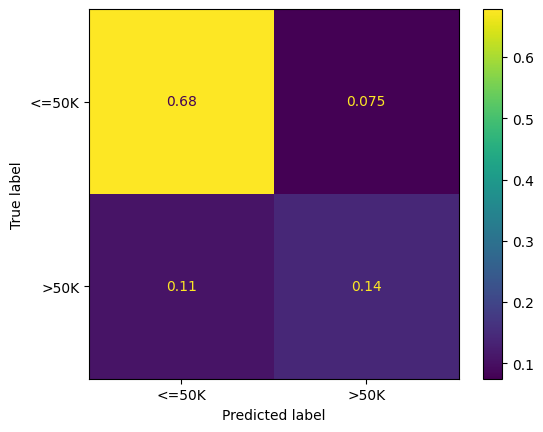

In [260]:
ConfusionMatrixDisplay.from_predictions(
    test_data[y], y_pred_KNN, normalize='all'
)
plt.show()

Nicht viele False_postives oder False_negatives dabei!

### Anzahl Features Check

In [261]:
steps = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(sparse=False), cat_features),
    ]
)
steps.fit_transform(train_data[cat_features])

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [262]:
pre_transform = train_data[cat_features].shape[1]
after_transform = steps.transform(train_data[cat_features]).shape[1]
print(f"Vor der Transformation gab es {pre_transform} Features, danach {after_transform}!")

Vor der Transformation gab es 12 Features, danach 115!


#### Test von PCA ob Feature Reduktion sinnvoll

In [263]:
components = 25
pca = PCA(n_components=components)
pca.fit_transform(steps.fit_transform(train_data[cat_features]))

array([[ 0.4421727 , -0.90349494, -0.09099922, ...,  0.0417628 ,
        -0.0726767 , -0.0047557 ],
       [-1.08339323, -0.15701543,  1.0231953 , ...,  0.33727906,
         0.60142156, -0.32147754],
       [ 0.28307604, -0.48644142,  0.84954207, ...,  0.23667843,
         0.51176295,  0.26841648],
       ...,
       [ 0.78525372, -1.12624489, -0.42595938, ...,  0.02327999,
        -0.25230377, -0.03356523],
       [-1.10937937, -0.08233368, -0.11920365, ...,  0.2240286 ,
         0.33312334, -0.09655445],
       [ 0.15550677,  1.01125594,  0.33619405, ..., -0.19917108,
        -0.81866252,  0.47661392]])

In [264]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.15081467, 0.21852571, 0.27938867, 0.32929612, 0.37593631,
       0.41813474, 0.45674769, 0.49136364, 0.52456444, 0.55455862,
       0.58024019, 0.60469849, 0.62710625, 0.64742062, 0.66727102,
       0.68575726, 0.70416614, 0.720872  , 0.73678993, 0.75211125,
       0.76669497, 0.78081961, 0.79389697, 0.80597113, 0.81782764])

Wir merken: 25 componenten erklären nur 81% der Varianz. Versuchen wir es mit mehr.

In [265]:
components = 70
pca = PCA(n_components=components)
pca.fit_transform(steps.fit_transform(train_data[cat_features]))

array([[ 4.42172825e-01, -9.03509498e-01, -9.09999390e-02, ...,
         1.28563496e-03,  8.59750058e-04, -1.89936728e-03],
       [-1.08339408e+00, -1.56998316e-01,  1.02318388e+00, ...,
        -5.59796988e-03,  6.20466484e-03,  9.32156205e-04],
       [ 2.83075961e-01, -4.86424776e-01,  8.49549185e-01, ...,
         7.14431590e-04, -7.33959853e-03,  4.08909919e-04],
       ...,
       [ 7.85253648e-01, -1.12624489e+00, -4.25955572e-01, ...,
         2.18369081e-03, -1.16441144e-03, -4.48579228e-03],
       [-1.10937915e+00, -8.23622042e-02, -1.19223074e-01, ...,
        -6.16300709e-04,  7.39932604e-03,  3.45517468e-03],
       [ 1.55506932e-01,  1.01122014e+00,  3.36182077e-01, ...,
         2.73244956e-03,  9.35221682e-03,  4.41268443e-03]])

In [266]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.15081467, 0.21852571, 0.27938867, 0.32929612, 0.37593631,
       0.41813474, 0.45674769, 0.49136366, 0.52456446, 0.55455866,
       0.58024025, 0.60469876, 0.62710659, 0.64742162, 0.66727228,
       0.68575915, 0.70416841, 0.72087455, 0.7367951 , 0.75211765,
       0.76670333, 0.78084418, 0.79393199, 0.80601106, 0.81787408,
       0.82898683, 0.83849349, 0.84787604, 0.85689901, 0.86548663,
       0.87319282, 0.88035952, 0.8871924 , 0.8938911 , 0.9003004 ,
       0.9064156 , 0.9124532 , 0.91826488, 0.92384368, 0.92908719,
       0.93418613, 0.93900668, 0.94353888, 0.94792566, 0.95215899,
       0.95583972, 0.95921509, 0.96243684, 0.96519419, 0.96784996,
       0.97037416, 0.97282472, 0.97507805, 0.977219  , 0.97932486,
       0.98108252, 0.98274978, 0.98416179, 0.9855295 , 0.98688529,
       0.98798389, 0.9889237 , 0.98976257, 0.9905298 , 0.99117123,
       0.991798  , 0.99236059, 0.99284619, 0.99331056, 0.9937476 ])

In [267]:
d = np.argmax(cumsum >= 0.95) + 1

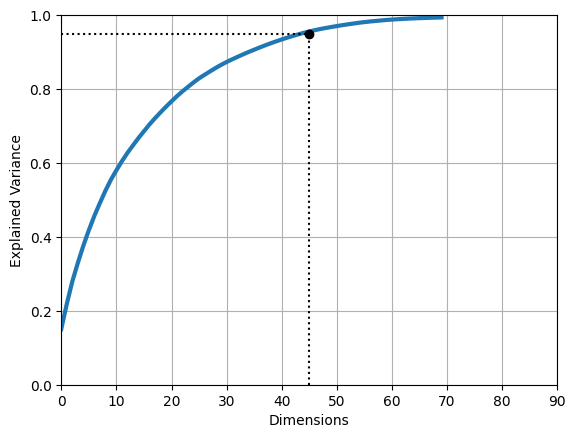

In [268]:
plt.plot(cumsum, linewidth=3)
plt.axis([0, 90, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()

In [269]:
print(f"Erklärte Varianz mit {components} Komponenten: {np.sum(pca.explained_variance_ratio_)}")
print(f"Erklärte Varianz mit {d} Komponenten: {np.sum(pca.explained_variance_ratio_[:46])}")

Erklärte Varianz mit 70 Komponenten: 0.9937475965009193
Erklärte Varianz mit 45 Komponenten: 0.9558397228320061


Frage: Verändert sich der Score wenn wir nur 45 Features mit reinnehmen?

In [270]:
num_step_2 = Pipeline(
    steps=[
        ("std_scaler", StandardScaler()),
    ]
)
prep_steps_2 = ColumnTransformer(
    transformers=[
        ("num", num_step_2, num_features),
        ("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"), cat_features),
    ],
    remainder="drop",
)
prep_steps_2.fit(train_data)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['fnlwgt', 'education-num']),
                                ('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['age', 'workclass', 'education',
                                  'marital_status', 'occupation',
                                  'relationship', 'race', 'sex', 'capitalgain',
                                  'capitalloss', 'hoursperweek',
                                  'native-country'])])

In [271]:
f_out_2 = prep_steps_2.get_feature_names_out().tolist()
ohe_cols_ix_2 = [f_out_2.index(x) for x in f_out_2 if x.startswith("ohe__")]
ct_pca_2 = ColumnTransformer(
    remainder="passthrough", transformers=[("pca", PCA(n_components=45), ohe_cols_ix_2)]
)
prep_2 = Pipeline(
    [
        ("preprocessing", prep_steps_2),
        ("ct_pca", ct_pca_2),
    ]
)
pipeline_2 = Pipeline([("prep", prep_2), ("model", KNeighborsClassifier(2))])
pipeline_2.fit(train_data[X], train_data[y])

c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('prep',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['fnlwgt',
                                                                    'education-num']),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['age',
                                                                    'workclass',
                                                                    'education',
                                                                    'marital_status',
                                                                    'occupation',
                                                                    'relationship',
                                                                    'race',
                                                                    'sex',
                                                                    'capitalgain',
                                                                    'capitalloss',
                                                                    'hoursperweek',
                                                                    'native-country'])])),
                                 ('ct_pca',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pca',
                                                                   PCA(n_components=47),
                                                                   [2, 3, 4, 5,
                                                                    6, 7, 8, 9,
                                                                    10, 11, 12,
                                                                    13, 14, 15,
                                                                    16, 17, 18,
                                                                    19, 20, 21,
                                                                    22, 23, 24,
                                                                    25, 26, 27,
                                                                    28, 29, 30,
                                                                    31, ...])]))])),
                ('model', KNeighborsClassifier(n_neighbors=2))])

In [272]:
pipeline_2.score(test_data[X], test_data[y])

0.8019385987542844

Ergebnis: Reduktion der Features nicht sinnvoll, Score um 2 Punkte gedropt.

### For Schleife mit mehreren Classifiern, Scalern, Transformern.
+ Ermittlung der besten/geeignesten

In [273]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
cat_transformers = [OneHotEncoder(), OrdinalEncoder()]

In [494]:

classifiers = [
    DecisionTreeClassifier(random_state=42),
    SVC(),
    LogisticRegression(max_iter=500),
    KNeighborsClassifier(2),
    RandomForestClassifier(),
    ]

In [495]:
# 1. Erstelle Df um Ergebnisse zu storen
models_df = pd.DataFrame()

# 2. Pipeline Prep
Pipeline_Cl = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('classifier',  None)
])

# 3. For Schleife per Model
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in cat_transformers:
            #testen der models und num/cat transformers
            Pipeline_Cl_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            Pipeline_Cl.set_params(**Pipeline_Cl_params)
            
            #check performnce und fit
            start_time = time.time()
            fit = Pipeline_Cl.fit(train_data[X], train_data[y])
            end_time = time.time()
            score = Pipeline_Cl.score(test_data[X], test_data[y])
                        
            parameter_dict = {
                            'model': model.__class__.__name__,
                            'num_trans': num_tr.__class__.__name__,
                            'cat_trans': cat_tr.__class__.__name__,
                            'score': score,
                            'time_elapsed': end_time - start_time,                            
            }
            
            models_df = models_df.append(pd.DataFrame(parameter_dict, index=[0]))
                    
models_df.reset_index(drop=True, inplace=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d ar

In [496]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
12,LogisticRegression,StandardScaler,OneHotEncoder,0.853315,0.442595
14,LogisticRegression,MinMaxScaler,OneHotEncoder,0.853278,0.571501
16,LogisticRegression,RobustScaler,OneHotEncoder,0.853278,0.434839
8,SVC,MinMaxScaler,OneHotEncoder,0.852689,18.482041
10,SVC,RobustScaler,OneHotEncoder,0.851730,19.291353
6,SVC,StandardScaler,OneHotEncoder,0.851472,20.715268
27,RandomForestClassifier,MinMaxScaler,OrdinalEncoder,0.832566,2.146731
29,RandomForestClassifier,RobustScaler,OrdinalEncoder,0.831349,2.024408
25,RandomForestClassifier,StandardScaler,OrdinalEncoder,0.831276,2.210223
24,RandomForestClassifier,StandardScaler,OneHotEncoder,0.828954,22.854242


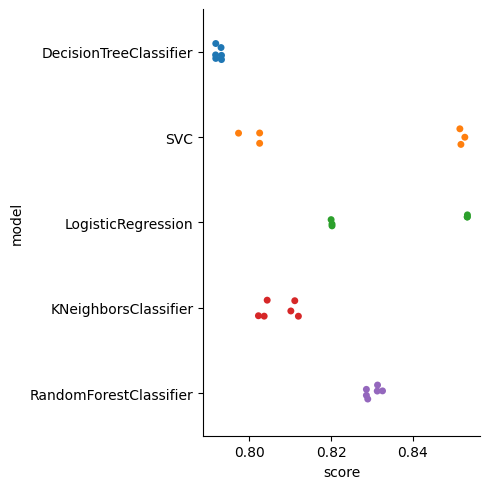

In [497]:
sns.catplot(data=models_df, x='score', y='model')


### Hyperparameter & GridSearch

#### Try RandomizesSearchCV

In [318]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [325]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=500, random_state=0)

In [326]:
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

In [327]:
clf = RandomizedSearchCV(logistic, distributions, random_state=0)

In [328]:
search = clf.fit(train_data[X], train_data[y].values.ravel())

In [329]:
search.best_params_

{'C': 2.195254015709299, 'penalty': 'l1'}

In [330]:
search.best_score_

0.7508845658965944

Schlechte performance, daher Versuch von GridSearch

In [287]:
from sklearn.preprocessing import LabelEncoder
for col in train_data.columns:
    if train_data[col].dtypes == 'object':
        le = LabelEncoder()
        
        train_data[col] = le.fit_transform(train_data[col].astype(str))

In [ ]:
for col in test_data.columns:
    if test_data[col].dtypes == 'object':
        le = LabelEncoder()
        
        test_data[col] = le.fit_transform(test_data[col].astype(str))

##### Kein GridSearch mit SVC

"The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples." - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

#### RandomForest Hyperparameter Tuning

In [483]:
rd_params = {
    'Classifier__max_depth': [90, 95, 134],
    'Classifier__n_estimators': [90, 95, 131],
    #'Classifier__random_state': [30, 40, 42]
}

In [479]:
pipe5 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Classifier', RandomForestClassifier())
])

In [484]:
GridSearch_rd = GridSearchCV(pipe5, rd_params) 

In [485]:
Grid_rd_results = GridSearch_rd.fit(train_data[X], train_data[y].values.ravel())

In [486]:
Grid_rd_results.best_score_

0.8302189479597984

In [487]:
Grid_rd_results.best_params_

{'Classifier__max_depth': 134, 'Classifier__n_estimators': 95}

#### KNN

In [374]:
knn_params = {
    'Classifier__n_neighbors': [2, 3, 5, 11, 19, 20, 30],
    'Classifier__weights': ['uniform', 'distance'],
    'Classifier__metric': ['euclidean', 'minkowski']
}

In [418]:
pipe4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Classifier', KNeighborsClassifier())
])

In [378]:
GridSearch_KNN = GridSearchCV(pipe4, knn_params) 

In [379]:
Grid_KNN_results = GridSearch_KNN.fit(train_data[X], train_data[y].values.ravel())

In [380]:
Grid_KNN_results.best_score_


0.8268468275157252

In [308]:
Grid_KNN_results.best_estimator_


KNeighborsClassifier(metric='euclidean', n_neighbors=19)

In [309]:
Grid_KNN_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}

##### Logistic Regression

In [280]:
import mlflow
import shap
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid

In [525]:
# parameter für logistic regression
C = np.logspace(-4, 4, 50, 100)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2']

In [526]:
#Grid
parameters = dict(logistic_Reg__C=C, 
                  logistic_Reg__penalty=penalty,
                  logistic_Reg__solver=solver)

In [527]:
lr_params = [{
    'Classifier__penalty': ['l1', 'l2'],
    'Classifier__C': np.logspace(0, 4, 20, 50, 100),
    'Classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
   
}]

In [528]:
pipe2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic_Reg', LogisticRegression(max_iter = 500))
])

In [529]:
clf_GS2 = GridSearchCV(pipe2, parameters, cv=5, n_jobs=1, verbose=1)

In [530]:
clf_GS2.fit(train_data[X], train_data[y].values.ravel())

Fitting 5 folds for each of 500 candidates, totalling 2500 fits



750 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Lennart Reschke\anaconda3\envs\ads3-06-dash\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('num_trans',
                                                                                          RobustScaler())]),
                                                                         ['fnlwgt',
                                                                          'education-num']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('cat_trans',
                                                                                          OrdinalEncoder())]),
                                                                         ['age',
                                                                          'workclass',
                                                                          'education',
                                                                          'marital_status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'capitalgain',
                                                                          'ca...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'logistic_Reg__solver': ['newton-cg', 'lbfgs',
                                                  'liblinear', 'sag', 'saga']},
             verbose=1)

In [533]:
print('Best Penalty:', clf_GS2.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS2.best_estimator_.get_params()['logistic_Reg__C'])
print(clf_GS2.best_estimator_.get_params()['logistic_Reg__solver'])

Best Penalty: l1
Best C: 0.019306977288832496
saga


In [532]:
clf_GS2.best_score_

0.8219818640951846

##### DecisionTreeClassifier

In [354]:
params = {
    'Classifier__max_depth': [2, 3, 5, 10, 20],
    'Classifier__min_samples_leaf': [5, 10, 20, 50, 100,150],
    'Classifier__criterion': ["gini", "entropy"]
}

In [355]:
pipe3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Classifier', DecisionTreeClassifier()),
])

In [353]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [386]:
grid_search_dt = GridSearchCV(pipe3, param_grid=params, cv=5, n_jobs=1, verbose=1, scoring = "accuracy")


In [382]:
grid_search_dt.fit(train_data[X], train_data[y])

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('num_trans',
                                                                                          RobustScaler())]),
                                                                         ['fnlwgt',
                                                                          'education-num']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('cat_trans',
                                                                                          OrdinalEncoder())]),
                                                                         ['age',
                                                                          'workclass',
                                                                          'education',
                                                                          'marital_status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'capitalgain',
                                                                          'capitalloss',
                                                                          'hoursperweek',
                                                                          'native-country'])])),
                                       ('Classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'Classifier__criterion': ['gini', 'entropy'],
                         'Classifier__max_depth': [2, 3, 5, 10, 20],
                         'Classifier__min_samples_leaf': [5, 10, 20, 50, 100,
                                                          150]})

In [383]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025331,0.007292,0.003185,0.000748,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.813156,0.816197,0.81592,0.820293,0.822781,0.81767,0.003424,47
1,0.024127,0.002772,0.004789,0.002222,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.813156,0.816197,0.81592,0.820293,0.822781,0.81767,0.003424,47
2,0.024131,0.003475,0.004393,0.001202,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.813156,0.816197,0.81592,0.820293,0.822781,0.81767,0.003424,47
3,0.021558,0.001030,0.002976,0.000018,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.813156,0.816197,0.81592,0.820293,0.822781,0.81767,0.003424,47
4,0.021535,0.001015,0.003192,0.000397,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.813156,0.816197,0.81592,0.820293,0.822781,0.81767,0.003424,47


In [384]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}

In [385]:
grid_search.best_score_

0.8391753486430777

In [297]:
dt_tuned = DecisionTreeClassifier(criterion="entropy",max_depth=10,min_samples_leaf=10)
dt_tuned.fit(train_data[X],train_data[y])

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10)

In [298]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

In [405]:
y_pred_dt_tuned = dt_tuned.predict(test_data[X])
print("Decision Tree Classifier:")
print('Accuracy score:', round(accuracy_score(test_data[y], y_pred_dt_tuned) * 100, 3))
print("F1 Score: ", round(f1_score(test_data[y],y_pred_dt_tuned) * 100,3))
print("MSE: ", round(mean_squared_error(test_data[y],y_pred_dt_tuned) * 100,3))

Decision Tree Classifier:
Accuracy score: 84.06
F1 Score:  65.953
MSE:  15.94


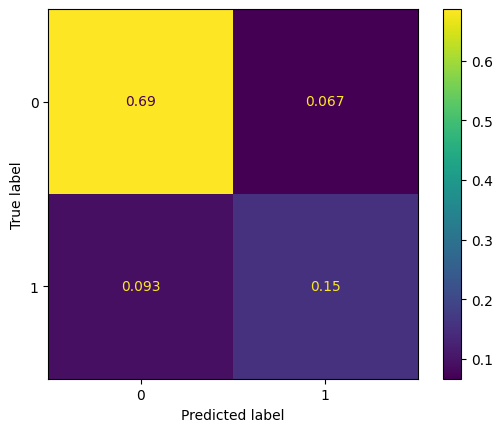

In [406]:
ConfusionMatrixDisplay.from_predictions(
    test_data[y], y_pred_dt_tuned, normalize='all'
)
plt.show()

### Zum Abschluss nochmal For Schleife mit getuneten Parameters

In [538]:

classifiers_tuned = [
    DecisionTreeClassifier(criterion="entropy",max_depth=10,min_samples_leaf=10,random_state=42),
    SVC(),
    LogisticRegression(penalty='l1', C=0.019306977288832496, solver='saga' ,max_iter=500),
    KNeighborsClassifier(n_neighbors = 19, weights = 'uniform', metric = 'euclidean'),
    RandomForestClassifier(n_estimators = 95, max_depth = 134)
    ]


In [535]:
# 1. Erstelle Df um Ergebnisse zu storen
models_df_tuned = pd.DataFrame()

# 2. Pipeline Prep
Pipeline_Cl = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('classifier',  None)
])

# 3. For Schleife per Model
for model in classifiers_tuned:
    for num_tr in scalers:
        for cat_tr in cat_transformers:
            #testen der models und num/cat transformers
            Pipeline_Cl_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            Pipeline_Cl.set_params(**Pipeline_Cl_params)
            
            #check performnce und fit
            start_time = time.time()
            fit = Pipeline_Cl.fit(train_data[X], train_data[y].values.ravel())
            end_time = time.time()
            score = Pipeline_Cl.score(test_data[X], test_data[y].values.ravel())
            
            parameter_dict = {
                            'model': model.__class__.__name__,
                            'num_trans': num_tr.__class__.__name__,
                            'cat_trans': cat_tr.__class__.__name__,
                            'score': score,
                            'time_elapsed': end_time - start_time
                            
            }
            
            models_df_tuned = models_df_tuned.append(pd.DataFrame(parameter_dict, index=[0]))
                    
models_df_tuned.reset_index(drop=True, inplace=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

In [536]:
models_df_tuned.sort_values('score', ascending = False)

,model,num_trans,cat_trans,score,time_elapsed
8,SVC,MinMaxScaler,OneHotEncoder,0.852689,19.858228
10,SVC,RobustScaler,OneHotEncoder,0.851730,20.352417
6,SVC,StandardScaler,OneHotEncoder,0.851472,24.505112
14,LogisticRegression,MinMaxScaler,OneHotEncoder,0.844396,2.583759
12,LogisticRegression,StandardScaler,OneHotEncoder,0.842406,5.459771
16,LogisticRegression,RobustScaler,OneHotEncoder,0.842295,5.469917
3,DecisionTreeClassifier,MinMaxScaler,OrdinalEncoder,0.840600,0.129651
5,DecisionTreeClassifier,RobustScaler,OrdinalEncoder,0.840600,0.145182
1,DecisionTreeClassifier,StandardScaler,OrdinalEncoder,0.840600,0.214494
0,DecisionTreeClassifier,StandardScaler,OneHotEncoder,0.839568,0.478245


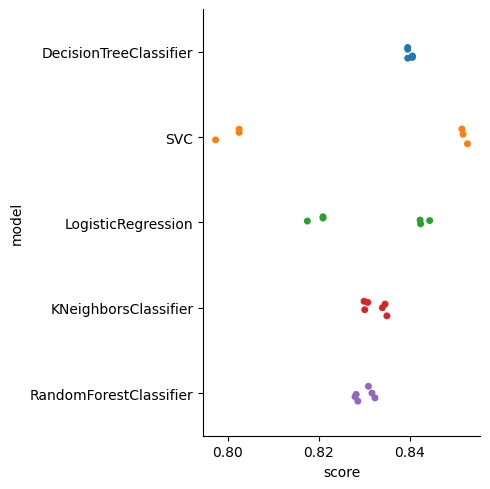

In [537]:
sns.catplot(data=models_df_tuned, x='score', y='model')

to be checked: MSE of SVC vs Logistic Regression ohne HyperparameterTuning und danach dann ConfusionMatrix

### MSE & F1 Score of Logistic Regression tuned und SVC nicht tuned, inkl. Confusion Matrix

##### Logistic Regression

In [541]:
Pipeline_LR_tuned = Pipeline( steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', C=0.019306977288832496, solver='saga' ,max_iter=500))    
    ])

In [556]:
Pipeline_LR_tuned.fit(train_data[X], train_data[y].values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   MinMaxScaler())]),
                                                  ['fnlwgt', 'education-num']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder())]),
                                                  ['age', 'workclass',
                                                   'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex', 'capitalgain',
                                                   'capitalloss',
                                                   'hoursperweek',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=0.019306977288832496, max_iter=500,
                                    penalty='l1', solver='saga'))])

In [557]:
Pipeline_LR_tuned.score(test_data[X], test_data[y])

0.8444329782921166

In [568]:
LR_tuned = Pipeline_LR_tuned.predict(test_data[X])

print("F1 Score: ", round(f1_score(test_data[y],LR_tuned) * 100,3))
print("MSE: ", round(mean_squared_error(test_data[y],LR_tuned) * 100,3))

F1 Score:  64.104
MSE:  15.557


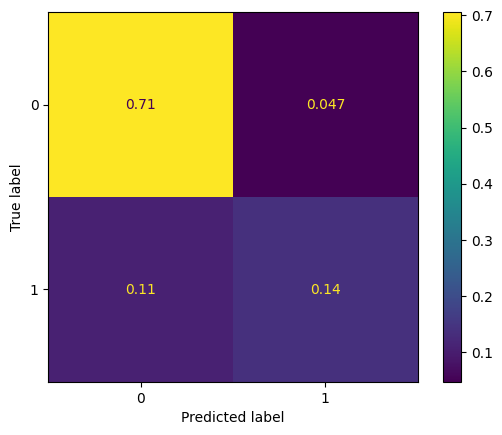

In [559]:
ConfusionMatrixDisplay.from_predictions(
    test_data[y], LR_tuned, normalize='all'
)
plt.show()

##### SVC

In [560]:
Pipeline_SVC = Pipeline( steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())    
    ])

In [561]:
Pipeline_SVC.fit(train_data[X], train_data[y])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   MinMaxScaler())]),
                                                  ['fnlwgt', 'education-num']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder())]),
                                                  ['age', 'workclass',
                                                   'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex', 'capitalgain',
                                                   'capitalloss',
                                                   'hoursperweek',
                                                   'native-country'])])),
                ('classifier', SVC())])

In [562]:
Pipeline_SVC.score(test_data[X], test_data[y])

0.8526886079681568

In [563]:
SVC2 = Pipeline_SVC.predict(test_data[X])

print("F1 Score: ", round(f1_score(test_data[y],SVC2) * 100,3))
print("MSE: ", round(mean_squared_error(test_data[y],SVC2) * 100,3))

F1 Score:  66.65
MSE:  14.731


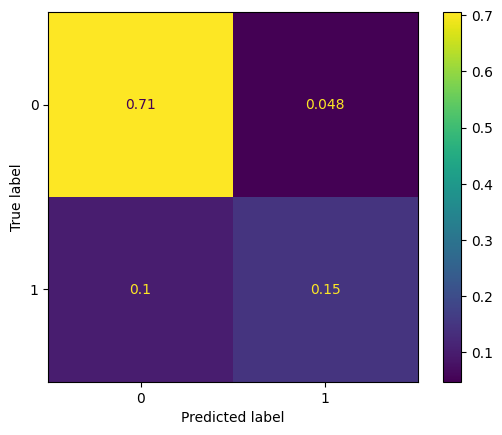

In [564]:
ConfusionMatrixDisplay.from_predictions(
    test_data[y], SVC2, normalize='all'
)
plt.show()